In [2]:
from IPython import display
import numpy as np
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

batch_size = 256
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# softmax回归的从零开始实现

就像从零开始实现线性回归一样，
实现softmax回归的细节

## softmax回归基础

\begin{example}\label{example:imageClass}
图像分类问题：假设每次输入是一个$2\times2$的灰度图像。
\begin{itemize}
    \item 可以用一个标量表示每个像素值，每个图像对应四个特征$x_1, x_2, x_3, x_4$。
    \item 假设每个图像属于类别“猫”、“鸡”和“狗”中的一个
\end{itemize}
\end{example}

\begin{problem}\label{prob:multioutputLabel}
如何表示类别标签？
\end{problem}


\begin{definition}\label{def:onehot}
**独热编码**（one-hot encoding）：是一个向量，它的分量和类别一样多；
**类别对应的分量设置为1**，其他所有分量设置为0。
\end{definition}


在Example \ref{example:imageClass}中，标签$y$将是一个三维向量：
- $(1, 0, 0)$对应于“猫”
- $(0, 1, 0)$对应于“鸡”
- $(0, 0, 1)$对应于“狗”

$$y \in \left\{(1, 0, 0), (0, 1, 0), (0, 0, 1)\right\}$$

### 网络架构

- 需要一个有多个输出的模型，每个类别对应一个输出

<center><img src="../img/3_linear_network/softmaxreg.svg" width=80%></center>

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

用矩阵形式表达

$$
\boldsymbol{o} = \mathbf{W} \boldsymbol{x} + \boldsymbol{b}
\label{eq:multioutputLinear}
$$


- softmax回归也是一个**单层神经网络**
- softmax回归的输出层也是**全连接层**

### softmax运算

- 希望模型的输出$\hat{y}_j$可以视为属于类$j$的概率，然后选择具有最大输出值的类别$\operatorname*{argmax}_j y_j$作为预测结果
    - 例，如果$\hat{y}_1$、$\hat{y}_2$和$\hat{y}_3$分别为0.1、0.8和0.1，则预测的类别是2

\begin{problem}\label{prob:linearProb}
式\eqref{eq:multioutputLinear}的结果作为概率是否可以？
\end{problem}


\begin{definition}\label{def:calibration}
**校准**（calibration）：一个训练的目标函数，来激励模型精准地估计概率
\end{definition}


- **softmax**函数能够将未规范化的预测变换为**非负数并且总和为1**，同时让模型保持**可导**的性质

$$
\hat{\boldsymbol{y}} = \mathrm{softmax}(\boldsymbol{o})\quad\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}
\label{eq:softmaxEquation}
$$

对于所有的$j$总有$0 \leq \hat{y}_j \leq 1$

社会科学家邓肯·卢斯于1959年的离散选择模型（choice model）

- softmax运算不会改变未规范化的预测$\boldsymbol{o}$之间的大小次序，只会确定分配给每个类别的概率

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j
$$

### 损失函数

- 假设整个数据集$\{\mathbf{X}, \mathbf{Y}\}$具有$n$个样本，
    - 其中索引$i$的样本由特征向量$\boldsymbol{x}^{(i)}$和独热标签向量$\boldsymbol{y}^{(i)}$组成

- softmax函数给出的向量$\hat{\boldsymbol{y}}$可以视为“对给定任意输入$\boldsymbol{x}$的每个类的条件概率”

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\boldsymbol{y}^{(i)} \mid \boldsymbol{x}^{(i)}).
$$

其中，$\mathbf{Y}\in\mathbb{R}^{n\times q}$，$\mathbf{X}\in\mathbb{R}^{n\times d}$，表示数据集有$n$个样本，有$d$个特征，$q$个类别

根据最大似然估计，**最大化**$P(\mathbf{Y} \mid \mathbf{X})$，相当于**最小化负对数似然**

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\boldsymbol{y}^{(i)} \mid \boldsymbol{x}^{(i)})
= \sum_{i=1}^n l(\boldsymbol{y}^{(i)}, \hat{\boldsymbol{y}}^{(i)}),
$$

对于任何标签$\boldsymbol{y}$和模型预测$\hat{\boldsymbol{y}}$，损失函数为

$$ l(\boldsymbol{y}, \hat{\boldsymbol{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\label{eq:crossEntropyLoss}
$$

\begin{definition}\label{def:crossEntropyLoss}
**交叉熵损失**（cross-entropy loss）：式\eqref{eq:crossEntropyLoss}定义的损失函数
\end{definition}


- 交叉熵表示对于真实的概率分布$P$，用概率分布$Q$近似的时候带来的预期惊异程度
- 符号表示为$H(P,Q)$：从$P$到$Q$的交叉熵

$$
H(P,Q)=-\sum_{x}P(x)\log Q(x)
$$

- 当$P=Q$时，交叉熵最小

### Softmax导数

- 根据softmax的定义可以得到：

$$
\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}
$$

- 对预测$o_j$的导数为

$$
\begin{split}
\frac{\partial l(\mathbf{y}, \hat{\mathbf{y}})}{\partial o_j} &= \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j\\
&= \hat{y}_j-y_j.
\end{split}
$$

- softmax的导数为softmax分配的概率与实际发生的情况（由独热标签向量表示）之间的差异

## 获取训练集和检验集数据

- 使用类似MNIST（Mixed National Institute of Standards and Technology）数据集但更复杂的Fashion-MNIST数据集

<center><img src="../img/3_linear_network/mnist.png" width=80%></center>

- Fashion-MNIST由10个类别的图像组成
    - 每个类别由训练数据集（train dataset）中的6000张图像和测试数据集（test dataset）中的1000张图像组成

- Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）

<center><img src="../img/3_linear_network/FashionMnist.png" width=80%></center> 

- 每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1

### 读取Fashion-MNIST数据集

 ```python
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
```

In [3]:
trans = transforms.ToTensor() # 将图像数据从PIL类型变换成32位浮点数格式；不然的话，数据类型是PIL.Image.Image
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=False)    # 创建训练集
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=False)   # 创建检验集

- ```python
torchvision.datasets.FashionMNIST(root: str, train: bool = True, transform: Optional[Callable] = None, download: bool = False)
```
    - `root`：存储数据的根目录，`str`类型
    - `train`：是否创建训练集，`bool`类型
    - `transform`：将PIL图像转变为的函数
    - `download`：是否从网络上下载数据，`bool`类型

- PIL (Python Image Library)：`Python`的第三方图像处理库
    - 处理栅格图像（*raster image*）

- 栅格图，也被称为位图（bitmap）、点阵图、像素图，是一个存储像素值的二维数组

<center><img src="../img/3_linear_network/raster.jpg" width=80%></center>

- 像素（pixel, picture element的缩写），构成栅格图的基本元素

- 图像的深度（depth）：一个像素包含的信息量（多少个bit）
    - 1bit，黑白图像
    - 8bit，灰度图像，取值范围0$\sim 2^8-1$

- 图像的分辨率（resolution）：一个图像包含的像素数量，通常表示为**长包含的像素数量$\times$宽包含的像素数量**

- 图像的通道（channel）：图像所包含的一种主要颜色的灰度图像。在该通道上的像素值表示这种颜色的强度
    - 例如用RGB表示的颜色，表明该图像有三通道，分别对应Red、Green、Blue三种颜色

In [4]:
f'训练集的长度 {len(mnist_train)}, 检验集的长度 {len(mnist_test)}'
f'每个图像的形状 {mnist_train[0][0].shape}'

'训练集的长度 60000, 检验集的长度 10000'

'每个图像的形状 torch.Size([1, 28, 28])'

In [5]:
mnist_train[5000]  # 是一个tuple，包含2个元素，分别是图像的数据信息和图像的类别标签，标签为0～9的数字

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.1725, 0.4980, 0.7137, 0.7255, 0.6314,
           0.4706, 0.2157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1647, 0.7765, 0.9843, 1.0000, 0.9843, 0.9765, 0.9686,
           1.0000, 0.9882, 0.8392, 0.3922, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000,
           0.0000, 0.9137, 0.9882, 0.9294, 0.9373, 0.9176, 0.9294, 0.9216,
           0.9294, 0.9294, 0.9961, 0.8902, 

In [6]:
def get_fashion_mnist_labels(labels):  
    ''' labels是一个标签向量（一系列类型为int的标签），把tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0])转换为['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']'''
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels] 

- 可视化数据集

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize) # return figs, axes
    axes = axes.flatten()   # 将(num_rows, num_cols)子图平展成(1, num_rows*num_cols)
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())   # 图片张量
        else:
            ax.imshow(img)           # PIL图片
        ax.axes.get_xaxis().set_visible(False)   # 隐藏横坐标
        ax.axes.get_yaxis().set_visible(False)   # 隐藏纵坐标
        if titles:
            ax.set_title(titles[i])  # 给图添加标题
    return axes

- ```python
Axes.imshow(X)
```
    - `X`：图像数据，可以是`array`，形状为(M,N)，也可以是PIL图像

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))  # 读取图像数据，批量为18

In [9]:
f'X的形状为 {X.shape}，y的形状为 {y.shape}'

'X的形状为 torch.Size([18, 1, 28, 28])，y的形状为 torch.Size([18])'

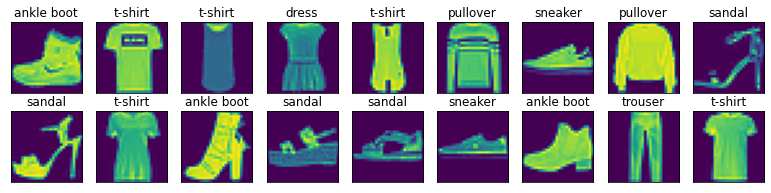

In [10]:
_ = show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))
# 显示图片
# X.reshape(18,28,28)，改变原来X的形状，符合show_images函数要求

### 小批量读取

- 利用`torch`内置的`DataLoader`函数批量读取数据

In [11]:
batch_size = 256  # 批量大小

def get_dataloader_workers():  
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,  # mnist_train类型：torchvision.datasets.mnist.FashionMNIST
                             num_workers=get_dataloader_workers())

/home/VENV36/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 完整的读取Fashion-MNIST数据集的函数

- 定义`load_data_fashion_mnist`函数，用于获取和读取Fashion-MNIST数据集：
    - 返回训练集和验证集的数据迭代器
    - 有一个可选参数resize，可以调整图像大小

In [12]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]   # 将图像从PIL类型转换成张量
    if resize:
        trans.insert(0, transforms.Resize(resize)) # resize是把小图片放大,在0之前插入
    trans = transforms.Compose(trans)   # 组合多个transform
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

- ```python
torchvision.transforms.Resize(size)
```
    - 缩放给定的图像
    - `size`：序列或者`int`
        - 若为序列，指定缩放后的长和宽
        - 若为`int`，图像的短边会改变到该数值，长边会被按比例缩放。例如，height>width,图像会被调整为($\text{size}\times\frac{\text{height}}{\text{width}}$,size)

- ```python
torchvision.transforms.Compose(transforms)
```
    - 组合多个transforms
    - `transforms`：`Transform`对象的列表

In [13]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
# 读取数据，批量为32，缩放到64像素

In [14]:
for X, y in train_iter:
    print(f'X的形状 {X.shape}, X的数据类型 {X.dtype}\n y的形状 {y.shape}, y的数据类型 {y.dtype}')
    break

X的形状 torch.Size([32, 1, 64, 64]), X的数据类型 torch.float32
 y的形状 torch.Size([32]), y的数据类型 torch.int64


## 实现softmax函数

- 用Fashion-MNIST数据集实现softmax分类算法
- 批量设置为256

In [15]:
batch_size = 256  # 批量大小
train_iter, test_iter = load_data_fashion_mnist(batch_size)   #读取批量数据

### 初始化模型参数

- 每个样本都将用固定长度的向量表示
    - 原始数据集中的每个样本都是$28 \times 28$的图像，在此**将展平每个图像，把它们看作长度为784的向量**

- 数据集有10个类别，所以网络输出维度为10
- 权重将构成一个$784 \times 10$的矩阵
- 偏置将构成一个$1 \times 10$的行向量

In [16]:
num_inputs = 784 # 1*28*28 = 784
num_outputs = 10

# 初始化模型参数
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)  # 初始化权重，服从正态分布N(0,0.01)
b = torch.zeros(num_outputs, requires_grad=True)   # 初始化偏置为0

### 定义softmax操作

- 对每个项指数运算（使用`exp`）；
- 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
- 将每一行除以其规范化常数，确保结果的和为1。

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

In [17]:
def softmax(X): # X的行数是样本数，因此每行有10个X_k,转成10个和为1的概率数
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

- ```python
torch.sum(input,dim,keepdim=False)
```
    - 给定一个矩阵`input`，可以对所有元素求和
    - 也可以只求同一个轴上的元素之和，即同一列（轴0）或同一行（轴1），用参数`dim`设定
    - 若按轴求和，求和之后这个轴的元素个数为１，所以对应的维度会被去掉，如果要保留这个维度，则应当`keepdim=True`

In [18]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [19]:
X.sum(0, keepdim=True) # 按轴求和之后保留维度，keepdim=True
X.sum(1, keepdim=True)

tensor([[5., 7., 9.]])

tensor([[ 6.],
        [15.]])

In [20]:
X.sum(0)   # 按轴求和后未保留维度
X.sum(1)  

tensor([5., 7., 9.])

tensor([ 6., 15.])

检验一下定义的softmax函数是否运行正确

In [21]:
X1 = torch.normal(0, 1, (2, 5))  # 生成一个2行5列的服从正态分布N(0,1)的矩阵
X1

tensor([[ 1.2986,  0.8923,  1.0202,  0.1019,  0.1728],
        [-1.1082, -1.8321, -0.7797, -1.2621, -0.4108]])

In [22]:
X1_prob = softmax(X1)
print(f'X1每个元素对应的概率为\n{X1_prob}\n X1每行求和{X1_prob.sum(1)}')

X1每个元素对应的概率为
tensor([[0.3279, 0.2184, 0.2482, 0.0991, 0.1064],
        [0.1742, 0.0845, 0.2420, 0.1494, 0.3499]])
 X1每行求和tensor([1.0000, 1.0000])


### 建立softmax回归模型

In [23]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

- 注意：`W`的形状是$784\times10$，因此用`reshape`将每张原始图像数据（$28\times28$）展平成一个长度为784向量

### 定义损失函数

- 实现交叉熵损失函数

In [24]:
def cross_entropy(y_hat, y):
    """
        y_hat：预测值
        y：真值
    """
    return - torch.log(y_hat[range(len(y_hat)), y])  # torch.log是以自然数e为底的对数函数

- 创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，以及它们对应的标签`y`

In [25]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([0, 2]) # 在第一个样本中，第1类是正确的预测； 而在第二个样本中，第3类是正确的预测
print(f'y_hat为\n{y_hat}')
print(f'y为 {y}')

y_hat为
tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])
y为 tensor([0, 2])


- 使用y作为y_hat中概率的索引， 选择第一个样本中第1类的概率和第二个样本中第3类的概率

In [26]:
y_hat[[0, 1], y] #【0，1】是样本序列，y是每个样本对应的真实分类标号

tensor([0.1000, 0.5000])

In [27]:
# 计算y_hat和y的交叉熵
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 评估准确率

- 分类须输出硬预测（hard prediction）时， 通常选择预测概率最高的类

- 将预测类别与真实`y`元素进行比较，当预测与标签分类y一致时，即是正确的

\begin{definition}\label{def:accuracy}
分类精度：正确预测数量与总预测数量之比
\end{definition}


#### 实现计算分类精度的函数

- y_hat是矩阵，假定第二个维度存储每个类的预测分数
- 使用argmax获得每行中最大元素的索引来获得预测类别

In [28]:
def accuracy(y_hat, y):  
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  #判断y_hat是一个矩阵
        y_hat = y_hat.argmax(axis=1)  # torch.argmax
    cmp = y_hat.type(y.dtype) == y    # 因为运算符==对数据类型敏感，将y_hat转换成与y相同的数据类型，便于比较
    return float(cmp.type(y.dtype).sum()) # cmp是bool向量，转换为与y相同的数据类型，可以求和

- ```python
torch.argmax(input, dim)
```
    - 返回指定维度上最大值的序号
    - `input`输入张量
    - `dim`指定的维度（轴）

- ```python
torch.Tensor.type(dtype=None)
```
    - `dtype`：需要的数据类型

In [29]:
print(f'预测值为\n{y_hat}')
print(f'真值为{y}')

预测值为
tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])
真值为tensor([0, 2])


- 第一个样本的预测类别是2，与真值**不符**
- 第二个样本的预测类别是2，与真值**相符**

In [30]:
# 在假想的预测值y_hat和真值y上的分类精度为
f'分类的精度为{accuracy(y_hat, y) / len(y)}'

'分类的精度为0.5'

#### 实现计算数据迭代器可访问数据集的分类精度

- 需要累计在每个批量上**预测正确的数量**与**预测的总数量**

- 定义`Accumulator`类
    - 创建2个变量，分别用于存储正确预测的数量和预测的总数量

In [31]:
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n  # 生成初始值为0的含n个元素的列表

    def add(self, *args):
        # 对n个变量分别累加
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]   # 类中定义__getitem__函数，可以获取指定序号的数据

- 构建可以评估任意模型`net`分类精度的函数

In [32]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 需要累计2个变量：正确预测数 和 预测总数
    with torch.no_grad():   # 不需要计算梯度
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [33]:
# 在给定的初始权重和偏置，构建的softmax回归模型的初始分类精度为
evaluate_accuracy(net, test_iter)

0.0918

### 建立优化器

- 小批量随机梯度下降优化模型的损失函数

In [34]:
def sgd(params, lr, batch_size):  # params: [w,b]
    """小批量随机梯度下降
    lr：学习速率
    """
    with torch.no_grad(): # 在该上下文管理器下，所有计算得出的tensor的requires_grad都自动设置为False。
        for param in params:
            param -= lr * param.grad / batch_size  # 更新参数，学习速率lr控制更新大小，批量大小batch_size规范化步长
            param.grad.zero_() 

In [35]:
lr = 0.1  # 学习速率

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

### Softmax回归的训练

### 定义一个函数来训练一个迭代周期

In [36]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """训练模型一个迭代周期（定义见第3章）
    net: 模型网络
    train_iter: 训练数据迭代器
    loss：损失函数
    updater：优化器
    """
    if isinstance(net, torch.nn.Module):
        # 将模型设置为训练模式
        net.train()
    metric = Accumulator(3) #累计3个变量：# 训练损失总和、训练准确度总和、样本数
    for X, y in train_iter:
        y_hat = net(X)  # 计算梯度并更新参数，得到预测值
        l = loss(y_hat, y)  # 计算损失
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()  # 反向计算梯度，注意pytorch内置优化器用mean函数将损失向量变为标量
            updater.step()       # 更新参数
        else:
            # 使用自己定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和分类精度
    return metric[0] / metric[2], metric[1] / metric[2]

### 定义一个动画绘制训练过程的类

In [37]:
class Animator:  
    """在动画中绘制训练过程"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()  # 用矢量图显式
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数，设置轴的属性
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]  # 变成列表，以便下方取y的长度
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            # 相同的x与每个y匹配（每个y代表一类数据，例如训练损失、训练分类精度、检验分类精度）
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()  # 清除轴
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [38]:
from IPython import display

def use_svg_display():
    # 显式矢量图在Jupyter中显式绘图
    display.set_matplotlib_formats('svg')

In [39]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)  # 设置x标签
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)  # 设置x轴的比例
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)      # 设置x轴的范围
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)  # 增添图例
    axes.grid()              # 打开网格

### 训练函数

- 会在`train_iter`访问到的训练数据集上训练一个模型`net`
- 训练函数会运行多个迭代周期（由`num_epochs`指定）
- 利用`Animator`类来可视化训练进度

In [40]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 评估在检验集上的分类精度
        test_acc = evaluate_accuracy(net, test_iter)
        # 横轴是迭代周期、纵轴包括三个值：训练损失、训练分类精度、检验分类精度
        # train_metrics是一个tuple，+(test_acc,)构成三个值的tuple
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

- 训练模型10个迭代周期

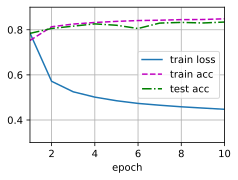

In [41]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 对图像进行分类预测

In [42]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签
    n：显示图像的数量
    """
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)   # 获得真实类别对应的类别名称
    # net(X).argmax(axis=1) 获得数据的硬预测
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]   # 真实和预测值对应的类别名称构成的列表
    _ = show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])  # 1行n列，注意改变图像数据的形状，去除通道维度

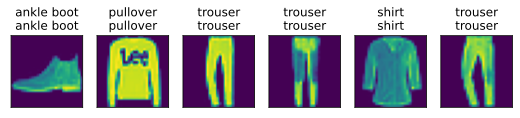

In [43]:
predict_ch3(net, test_iter)